In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import Resize, Normalize, ToTensor, Compose, RandomHorizontalFlip
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchsummary import summary
from tabulate import tabulate

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import os

import requests
import urllib.request
from urllib.parse import urlencode
import shutil
import zipfile

from lion_pytorch import Lion
from torch.optim import lr_scheduler

### Загрузка данных.


In [ ]:
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f'Размер обучающей выборки: {len(train_dataset)}')
print(f'Размер тестовой выборки: {len(test_dataset)}')


print('\nКлассы:')
print(tabulate(
    list(train_dataset.class_to_idx.items()), headers=['Название', 'Индекс'],
    tablefmt='pretty'
))


Размер обучающей выборки: 50000
Размер тестовой выборки: 10000

Классы:
+------------+--------+
|  Название  | Индекс |
+------------+--------+
|  airplane  |   0    |
| automobile |   1    |
|    bird    |   2    |
|    cat     |   3    |
|    deer    |   4    |
|    dog     |   5    |
|    frog    |   6    |
|   horse    |   7    |
|    ship    |   8    |
|   truck    |   9    |
+------------+--------+


C:\Users\User\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


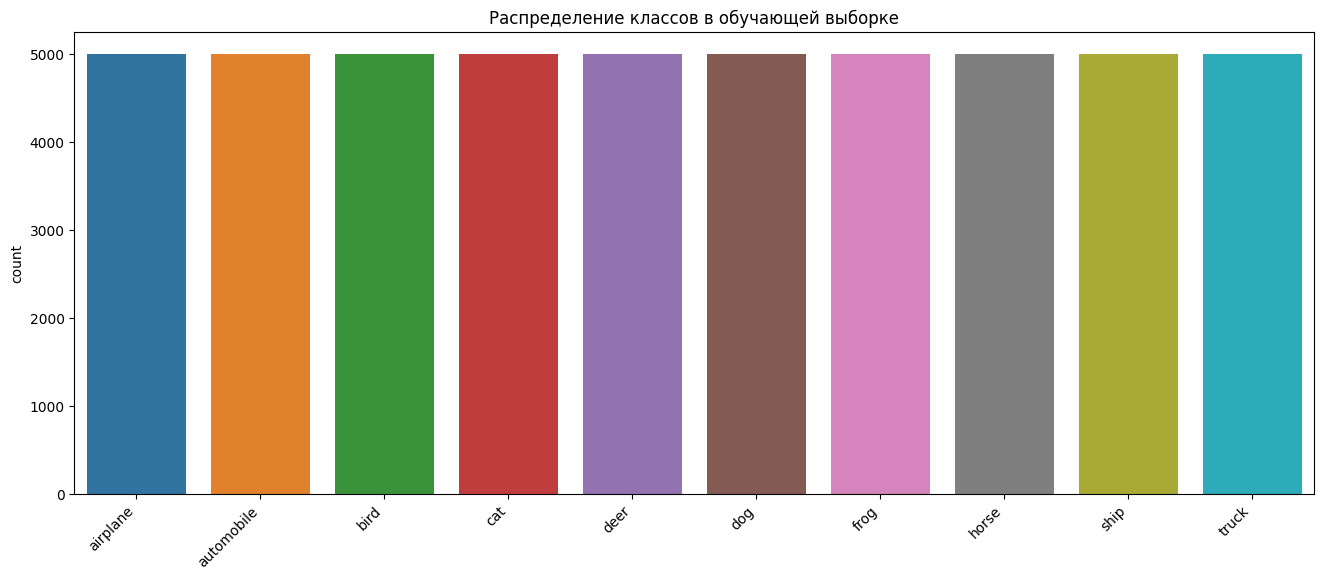

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


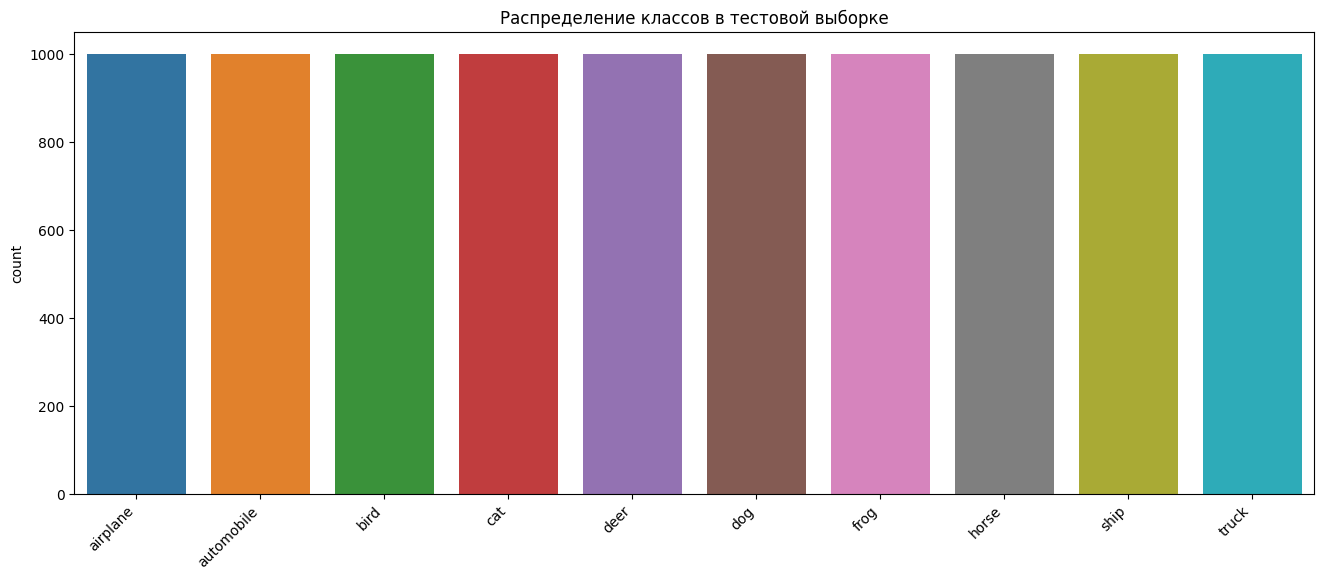

In [ ]:
index_to_label = {v: k for k, v in train_dataset.class_to_idx.items()}

fig, ax = plt.subplots(figsize=(16, 6))

class_labels_train = [index_to_label[idx] for idx in train_dataset.targets]
unique_labels_train = list(index_to_label.values())

sns.countplot(x=class_labels_train, order=unique_labels_train)
plt.title('Распределение классов в обучающей выборке')
plt.xticks(rotation=45, ha='right')
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))

class_labels_test = [index_to_label[idx] for idx in test_dataset.targets]
unique_labels_test = list(index_to_label.values())

sns.countplot(x=class_labels_test, order=unique_labels_test)
plt.title('Распределение классов в тестовой выборке')
plt.xticks(rotation=45, ha='right')
plt.show()


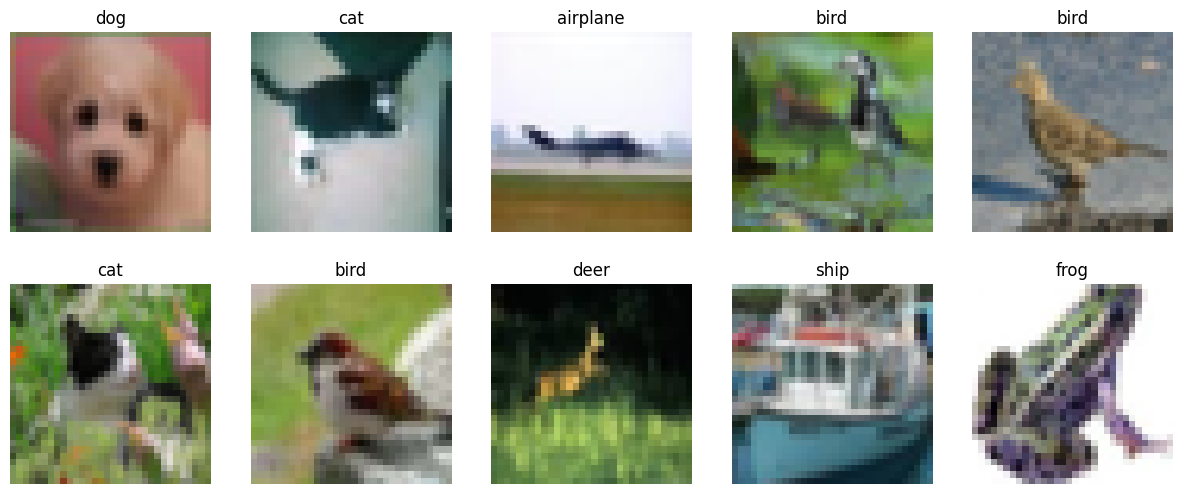

In [ ]:
class_names = test_dataset.classes

def show_images(images, labels):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(class_names[labels[i]])
        plt.imshow(np.clip(np.transpose(images[i], (1, 2, 0)), 0, 1))
        plt.axis('off')
    plt.show()

data_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
data_iter = iter(data_loader)
images, labels = next(data_iter)
show_images(images, labels)

**Вывод**:

1.  Мы имеем 50 000 в обучающей выборки и 10 000 в тестовой
2.  В каждом классе одинаковое количество классов, дисбаланса не наблюдается
3.  Изображения полностью соответствуют меткам класса

### Построение архитектуры сверточной сети.

#### Требуется вывести информацию об архитектуре, опционально выполнить визуализацию сети.

In [ ]:
width = 224
height = 224

transform = transforms.Compose([Resize((width,height)),
                                transforms.ToTensor()])

cifar10_train = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=256, shuffle=False)

mean = 0.
std = 0.
total_samples = 0.

for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Files already downloaded and verified
Mean: [0.4913995563983917, 0.48215848207473755, 0.44653093814849854]
Std: [0.19525285065174103, 0.19247294962406158, 0.1941993534564972]


In [ ]:
train_transform = transforms.Compose(
    [
        Resize((width,height)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.Normalize(mean, std)
    ]
)
test_transform = torchvision.transforms.Compose(
    [
        Resize((width,height)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)


train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class CustomEarlyStopping():
    def __init__(self, patience=5, min_delta=0, path="best_model.pt", path_model="best_model"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = None
        self.early_stop = False
        self.path = path
        self.path_model = path_model

    def __call__(self, test_accuracy, model, optimizer):
        if self.best_accuracy is None:
            self.best_accuracy = test_accuracy
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': test_accuracy,}, self.path)
            torch.save(model, self.path_model)

        elif test_accuracy - self.best_accuracy > self.min_delta:
            self.best_accuracy = test_accuracy
            self.counter = 0
            if os.path.exists(self.path):
                checkpoint = torch.load(self.path)
                if test_accuracy > checkpoint['best_accuracy']:
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_accuracy': test_accuracy,
                    }, self.path)
                    torch.save(model, self.path_model)
            else:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_accuracy': test_accuracy,
                }, self.path)
                torch.save(model, self.path_model)
        elif test_accuracy - self.best_accuracy < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            print(f"Best accuracy {self.best_accuracy}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


In [ ]:
class ClassificationTrainer:
    def __init__(self, model: nn.Module, name_optimizer: str, scheduler: bool, train_dataset: Dataset,
                 test_dataset: Dataset, batch_size:int, learning_rate: float, num_epochs: int,
                 coef=0.85, step_size=10):

        self.model = model
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()

        if name_optimizer == 'Lion':
            self.optimizer = Lion(self.model.parameters(), lr=learning_rate, weight_decay=1e-2)
        elif name_optimizer == 'AdamW':
            self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        else:
            raise NotImplementedError()

        if scheduler:
            self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=coef)
        else:
            self.scheduler = None

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.path = str(type(self.model).__name__) + '_' + str(type(self.optimizer).__name__) + ".pt"
        self.path_model =str(type(self.model).__name__) + '_' + str(type(self.optimizer).__name__)

        self.losses = {'train': [], 'test': []}
        self.accuracies = {'train': [], 'test': []}

    def train_one_epoch(self):
        self.model.to(self.device).train()
        epoch_loss = 0
        epoch_accuracy = 0
        with tqdm(total=len(self.train_loader)) as pbar:
            for i, batch in enumerate(self.train_loader):
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                output = self.model(inputs)

                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(output.detach(), 1)
                accuracy = accuracy_score(predicted.cpu().numpy(), labels.cpu().numpy())
                epoch_accuracy += accuracy
                epoch_loss += loss.item()

                pbar.set_description(f'Loss: {loss.item():.4f}; Accuracy: {accuracy:.4f}')
                pbar.update()

        self.losses['train'].append(epoch_loss / len(self.train_loader))
        self.accuracies['train'].append(epoch_accuracy / len(self.train_loader))

    def validate(self):
        self.model.to(self.device).eval()
        losses = []
        predicted_classes = []
        true_classes = []
        with tqdm(total=len(self.test_loader)) as pbar:
            with torch.no_grad():
                for i, batch in enumerate(self.test_loader):
                    inputs, labels = batch
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    self.optimizer.zero_grad()
                    output = self.model(inputs)

                    loss = self.criterion(output, labels)
                    losses.append(loss.item())

                    _, predicted = torch.max(output.detach(), 1)
                    predicted_classes.append(predicted)
                    true_classes.append(labels)


                    accuracy = accuracy_score(predicted.cpu().numpy(), labels.cpu().numpy())

                    pbar.set_description(f'Loss: {loss.item():.4f}; Accuracy: {accuracy:.4f}')
                    pbar.update()

        predicted_classes = torch.cat(predicted_classes).detach().to('cpu').numpy()
        true_classes = torch.cat(true_classes).detach().to('cpu').numpy()
        return losses, predicted_classes, true_classes

    def train(self):
        early_stopping = CustomEarlyStopping(patience=4, min_delta=0.005, path=self.path, path_model=self.path_model)
        for epoch in range(self.num_epochs):
            print('Epoch:', epoch)
            self.train_one_epoch()

            print('Validation')
            losses, predicted_classes, true_classes = self.validate()
            test_accuracy = accuracy_score(true_classes, predicted_classes)

            self.losses['test'].append(np.mean(losses))
            self.accuracies['test'].append(test_accuracy)
            clear_output(wait=True)
            print(f'Accuracy: {test_accuracy:.4f}')
            print()
            self.plot_training_history()

            if self.scheduler:
                self.scheduler.step()

            early_stopping(test_accuracy, self.model, self.optimizer)
            if early_stopping.early_stop:
                print('Early Stopping!!!')
                break

        clear_output(wait=True)
        print(f"Обучение завершено!!!")
        print(f"Best accuracy: {self.get_best_accuracy()}")

    def plot_training_history(self):
        len_data = len(self.losses['train'])
        plt.figure(figsize=(12, 4))

        # График функции потерь
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len_data + 1), self.losses['train'], marker='o', label='Training Loss')
        plt.plot(range(1, len_data + 1), self.losses['test'], marker='o', label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Test Loss')
        plt.grid(True)

        # График точности
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len_data + 1), self.accuracies['train'], marker='o', label='Training Accuracy')
        plt.plot(range(1, len_data + 1), self.accuracies['test'], marker='o', label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Test Accuracy')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_best_accuracy(self):
        checkpoint = torch.load(self.path)
        return checkpoint['best_accuracy']

В данной работе проведем transfer learning для AlexNet, ResNet34, MobileNet V2, EfficientNetV2. Так как данные модели обучались ранее на imagenet с размером 224x224, то и нам предется сделать Resize изображений. В качестве оптимизатора, попробуем обучить модели с помощью нового оптимизатора lion и старого доброго adam (https://github.com/lucidrains/lion-pytorch).
Обучим два типа моделей: с freeze слоев и полным fine tuning.

### AlexNet

#### freeze layers

In [ ]:
class AlexNetFreeze(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetFreeze, self).__init__()
        self.alexnet = models.alexnet( weights='DEFAULT')
        for param in self.alexnet.parameters(): param.requires_grad = False

        self.alexnet.classifier[6] = torch.nn.Linear(
            in_features=self.alexnet.classifier[6].in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [ ]:
input_size = (3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = AlexNetFreeze(num_classes=10)
alexnet = alexnet.to(device)


summary(alexnet, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

По итогу имеем **40 970** обучаемых параметров

Обучение завершено!!!
Best accuracy: 0.8021


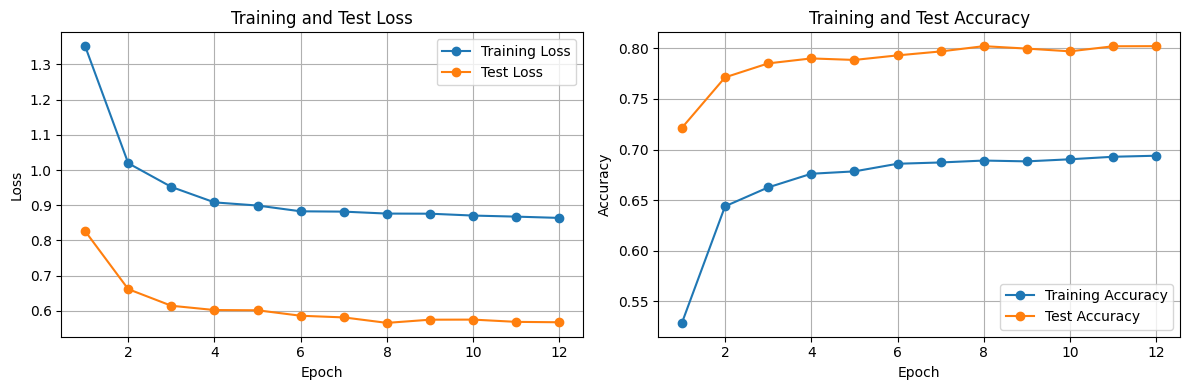

In [ ]:
freeze_alexnet_lion = ClassificationTrainer(model=alexnet,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=256,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
freeze_alexnet_lion.train()
freeze_alexnet_lion.plot_training_history()

Теперь обучим используя AdamW

Обучение завершено!!!
Best accuracy: 0.7865


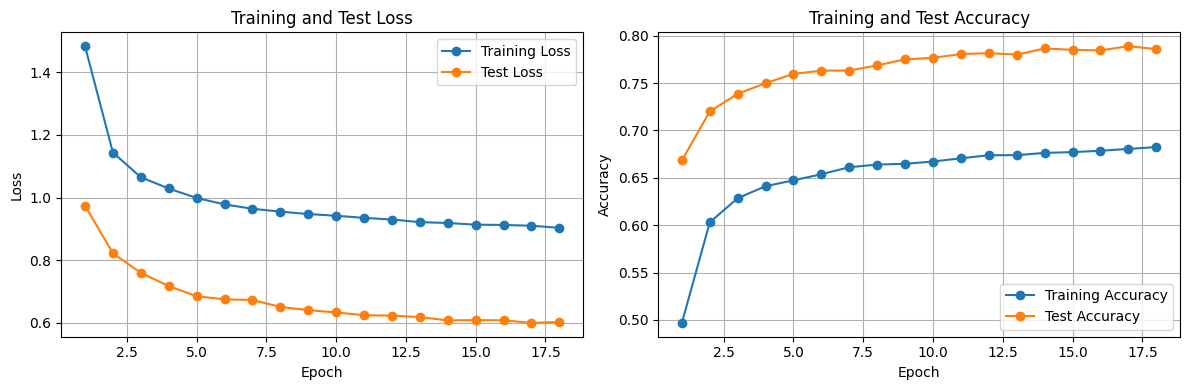

In [ ]:
alexnet = AlexNetFreeze(num_classes=10)

freeze_alexnet_adamw = ClassificationTrainer(model=alexnet,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=256,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
freeze_alexnet_adamw.train()
freeze_alexnet_adamw.plot_training_history()

На первый взгляд можно сказать, что для Lion необходимо гораздо меньше эпох для полного обучения (12 эпох против 18 у AdamW), также хочется сказать, что время, затраченное на одну эпоху у Lion меньше, чем у AdamW

#### finetuning

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.alexnet = models.alexnet( weights='DEFAULT')

        self.alexnet.classifier[6] = torch.nn.Linear(
            in_features=self.alexnet.classifier[6].in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [ ]:
input_size = (3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = AlexNet(num_classes=10)
alexnet = alexnet.to(device)


summary(alexnet, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

Обучение завершено!!!
Best accuracy: 0.9056


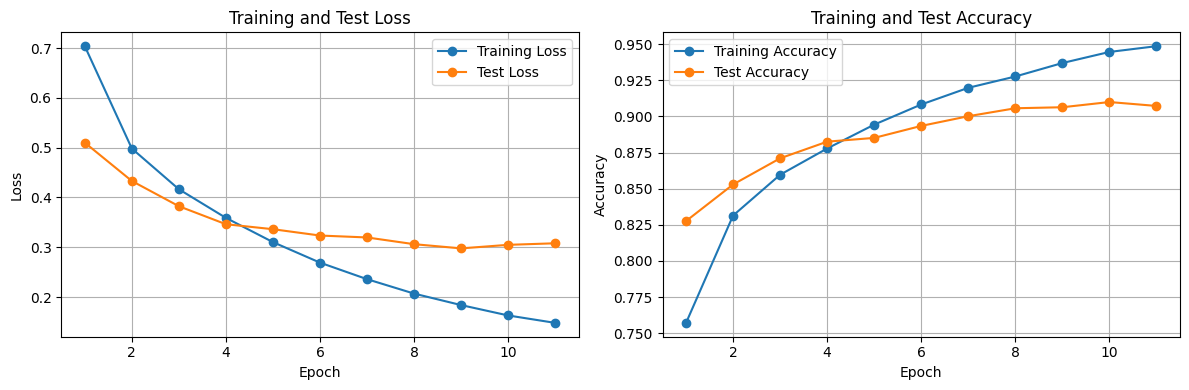

In [ ]:
trainer_alexnet_lion = ClassificationTrainer(model=alexnet,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=1,
                                         num_epochs=50)
trainer_alexnet_lion.train()
trainer_alexnet_lion.plot_training_history()

Отлично, при fine tuning всех слоев показал гораздо лучше результат, прирост почти на 10%

Обучение завершено!!!
Best accuracy: 0.9244


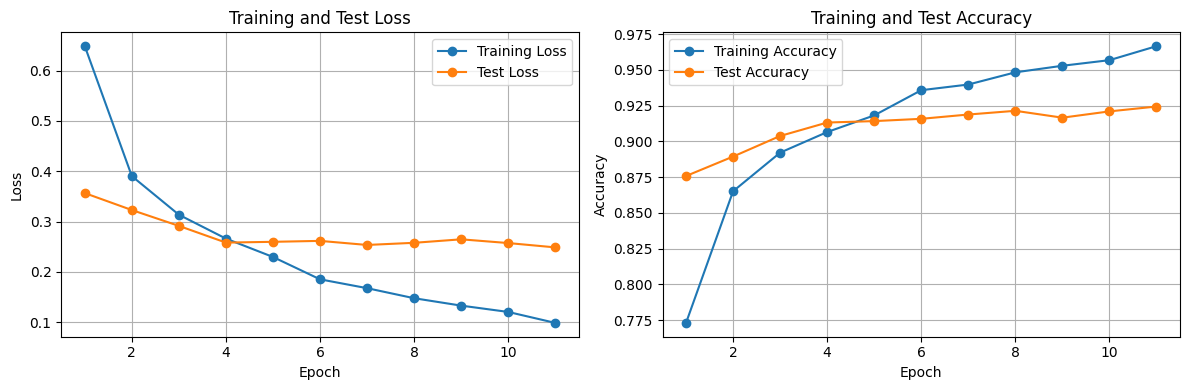

In [ ]:
alexnet = AlexNet(num_classes=10)

trainer_alexnet_adamw = ClassificationTrainer(model=alexnet,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
trainer_alexnet_adamw.train()
trainer_alexnet_adamw.plot_training_history()

Как видим, что при finetuning AdamW лучше сошелся, чем Lion. Была обучена модель 2012 года, теперь обучим модель 2015 года

### ResNet 34

In [ ]:
class ResNetFreeze(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFreeze, self).__init__()
        self.resnet34 = models.resnet34( weights='DEFAULT')
        for param in self.resnet34.parameters(): param.requires_grad = False

        self.resnet34.fc = torch.nn.Linear(
            in_features=self.resnet34.fc.in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.resnet34(x)

In [ ]:
resnet34 = ResNetFreeze(num_classes=10)
resnet34 = resnet34.to(device)


summary(resnet34, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Обучение завершено!!!
Best accuracy: 0.8284


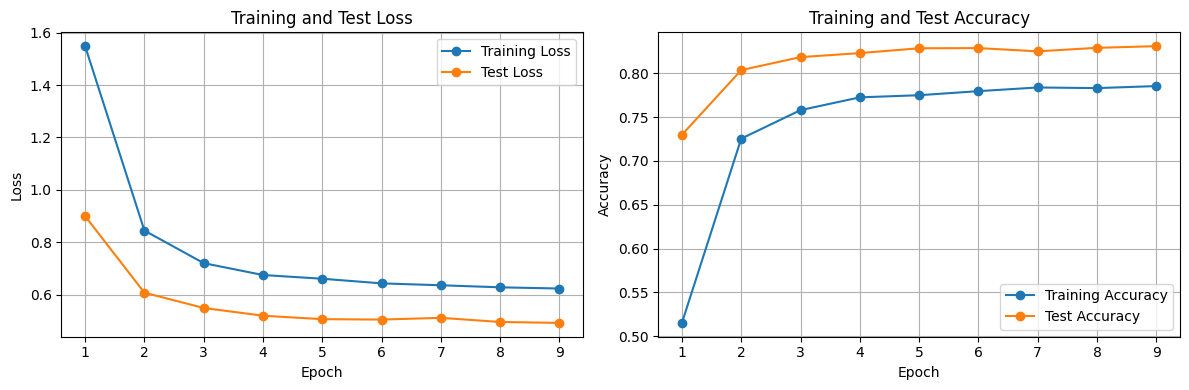

In [ ]:
freeze_resnet34_lion = ClassificationTrainer(model=resnet34,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
freeze_resnet34_lion.train()
freeze_resnet34_lion.plot_training_history()

Обучение завершено!!!
Best accuracy: 0.815


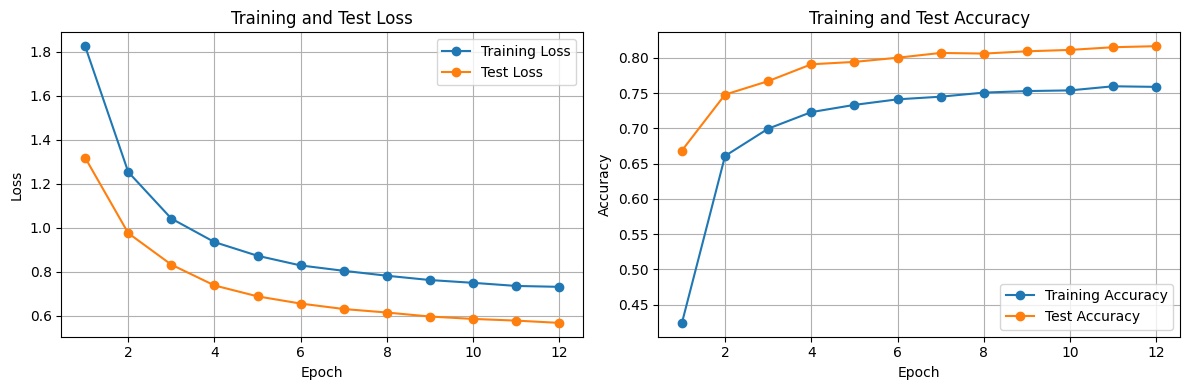

In [ ]:
resnet34 = ResNetFreeze(num_classes=10)
freeze_resnet34_adamw = ClassificationTrainer(model=resnet34,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
freeze_resnet34_adamw.train()
freeze_resnet34_adamw.plot_training_history()

Тенденция сохраняется, для freeze Lion обучает модели быстрее и лучше сходится

#### finetuning

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.resnet34 = models.resnet34( weights='DEFAULT')

        self.resnet34.fc = torch.nn.Linear(
            in_features=self.resnet34.fc.in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.resnet34(x)

In [ ]:
resnet34 = ResNet(num_classes=10)
resnet34 = resnet34.to(device)


summary(resnet34, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Обучение завершено!!!
Best accuracy: 0.9552


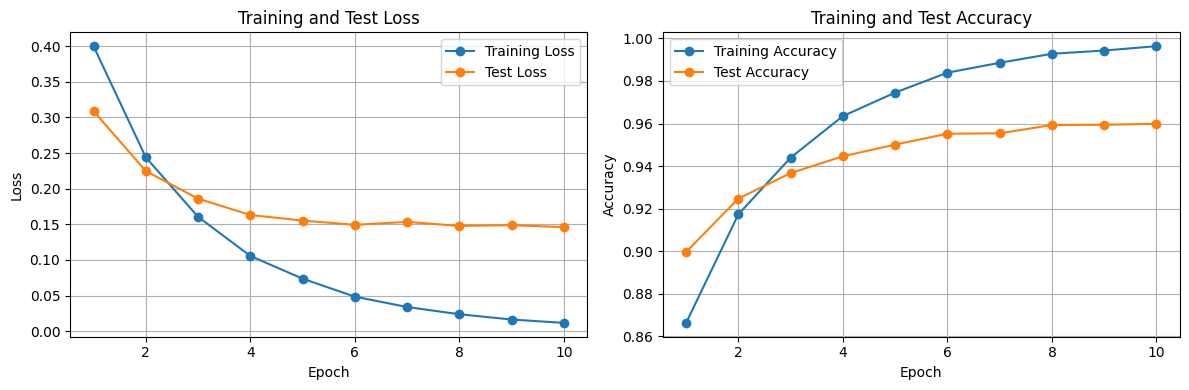

In [ ]:
trainer_resnet34_lion = ClassificationTrainer(model=resnet34,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.7,
                                         step_size=1,
                                         num_epochs=50)
trainer_resnet34_lion.train()
trainer_resnet34_lion.plot_training_history()

Обучение завершено!!!
Best accuracy: 0.9637


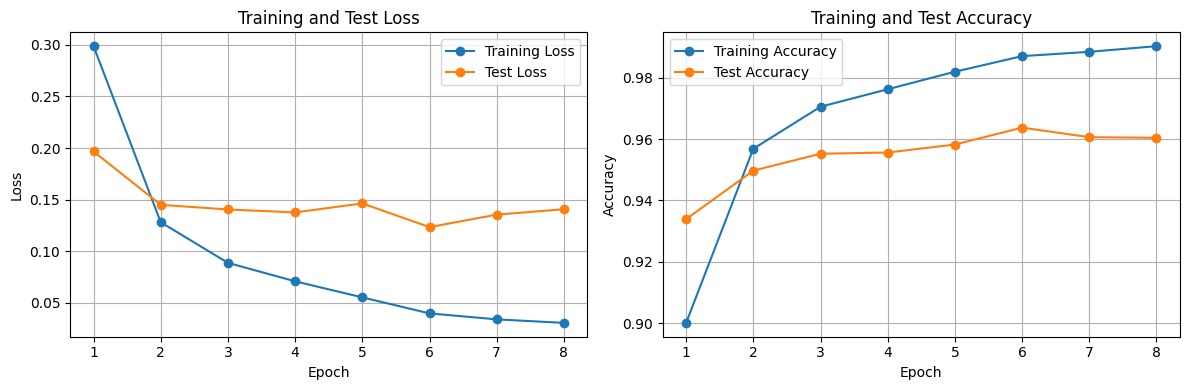

In [ ]:
resnet34 = ResNet(num_classes=10)
trainer_resnet34_adamw = ClassificationTrainer(model=resnet34,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=5,
                                         num_epochs=50)
trainer_resnet34_adamw.train()
trainer_resnet34_adamw.plot_training_history()

Отлично! Получили почти похожий результат, но **AdamW** чуть лучше справился с задачей в **96,37%**

Теперь посмотрим модель 2018 года

### MobileNet V2

In [ ]:
class MobileNetFreeze(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetFreeze, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2( weights='DEFAULT')
        for param in self.mobilenet_v2.parameters(): param.requires_grad = False

        self.mobilenet_v2.classifier[1] = torch.nn.Linear(
            in_features=self.mobilenet_v2.classifier[1].in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [ ]:
input_size = (3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet_v2 = MobileNetFreeze(num_classes=10)
mobilenet_v2 = mobilenet_v2.to(device)


summary(mobilenet_v2, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Обучение завершено!!!
Best accuracy: 0.7357


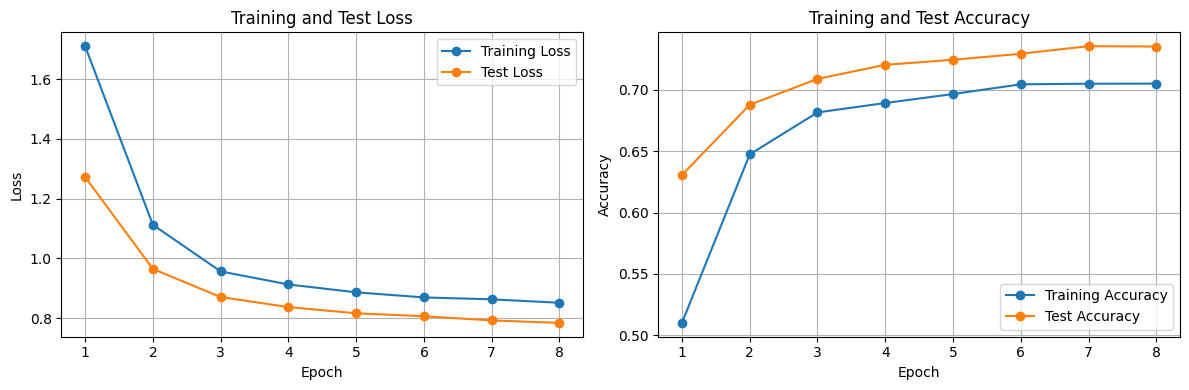

In [ ]:
freeze_mobilenet_v2_lion = ClassificationTrainer(model=mobilenet_v2,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=2,
                                         num_epochs=50)
freeze_mobilenet_v2_lion.train()
freeze_mobilenet_v2_lion.plot_training_history()

Обучение завершено!!!
Best accuracy: 0.6835


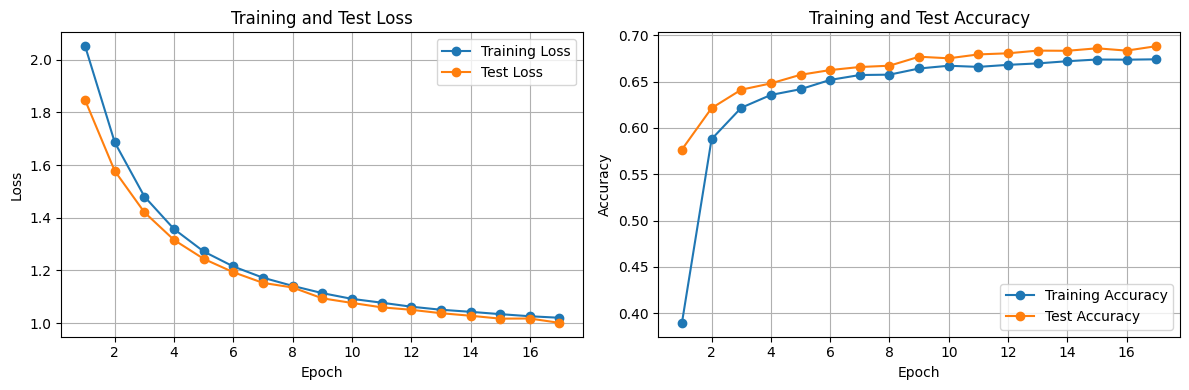

In [ ]:
mobilenet_v2 = MobileNetFreeze(num_classes=10)

freeze_mobilenet_v2_adamw = ClassificationTrainer(model=mobilenet_v2,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=256,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=2,
                                         num_epochs=50)
freeze_mobilenet_v2_adamw.train()
freeze_mobilenet_v2_adamw.plot_training_history()

Получили результат хуже, чем для ResNet

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, num_classes):
        super(MobileNet, self).__init__()
        self.mobilenet_v2 = models.mobilenet_v2( weights='DEFAULT')

        self.mobilenet_v2.classifier[1] = torch.nn.Linear(
            in_features=self.mobilenet_v2.classifier[1].in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.mobilenet_v2(x)

In [ ]:
mobilenet_v2 = MobileNet(num_classes=10)
mobilenet_v2 = mobilenet_v2.to(device)

summary(mobilenet_v2, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Обучение завершено!!!
Best accuracy: 0.9496


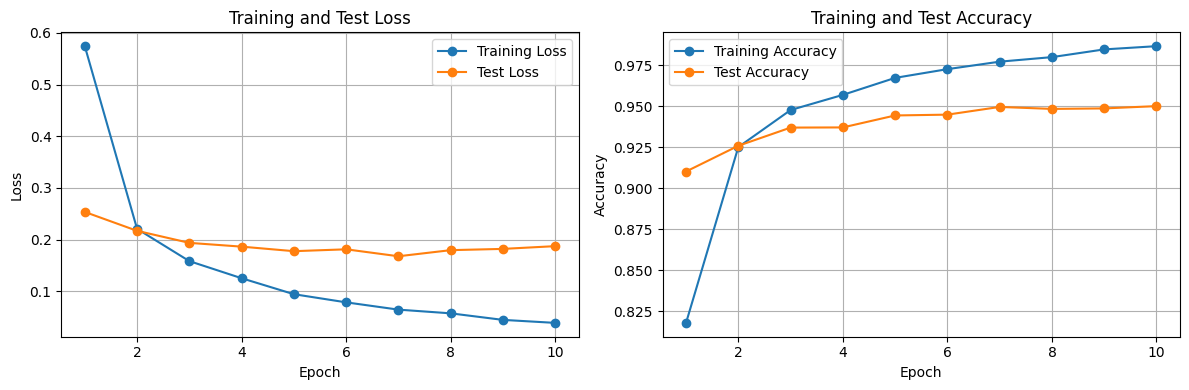

In [ ]:
trainer_mobilenet_v2_lion = ClassificationTrainer(model=mobilenet_v2,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=2,
                                         num_epochs=50)
trainer_mobilenet_v2_lion.train()
trainer_mobilenet_v2_lion.plot_training_history()

Обучение завершено!!!
Best accuracy: 0.9389


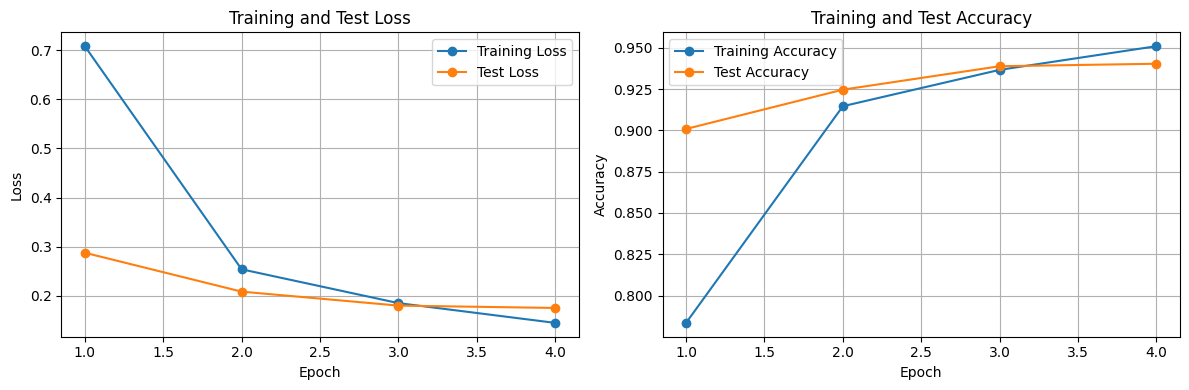

In [ ]:
mobilenet_v2 = MobileNet(num_classes=10)

trainer_mobilenet_v2_adamw = ClassificationTrainer(model=mobilenet_v2,
                                         name_optimizer='AdamW',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=2,
                                         num_epochs=50)
trainer_mobilenet_v2_adamw.train()
trainer_mobilenet_v2_adamw.plot_training_history()

Для finetuning мы получили сопоставимый результат с ResNet. Но обратим внимание, что у ResNet34 было **21 289 802** обучаемых параметров, в то время как у MobileNetV2 **2 236 682**


Далее у нас на очереди модель 2020 года. В данном случае в связи с тем, что полный finetuning модели занимает несколько часов, то мы обучим с freeze всех слоев. Единственное изменим слой классификации в первый раз на линейный слой, а второй раз на
```python
nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.efficientnet_v2_m.classifier[2].in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes))
```
И посмотрим на метрики

### EfficientNetv2

In [ ]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet, self).__init__()
        self.efficientnet_v2_m = models.convnext_base(weights='DEFAULT')
        for param in self.efficientnet_v2_m.parameters(): param.requires_grad = False

        self.efficientnet_v2_m.classifier[2] = torch.nn.Linear(
            in_features=self.efficientnet_v2_m.classifier[2].in_features,
            out_features=num_classes)

    def forward(self, x):
        return self.efficientnet_v2_m(x)

In [ ]:
input_size = (3, 224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

efficientnet_v2_m = EfficientNet(num_classes=10)
efficientnet_v2_m = efficientnet_v2_m.to(device)


summary(efficientnet_v2_m, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
       LayerNorm2d-2          [-1, 128, 56, 56]             256
            Conv2d-3          [-1, 128, 56, 56]           6,400
           Permute-4          [-1, 56, 56, 128]               0
         LayerNorm-5          [-1, 56, 56, 128]             256
            Linear-6          [-1, 56, 56, 512]          66,048
              GELU-7          [-1, 56, 56, 512]               0
            Linear-8          [-1, 56, 56, 128]          65,664
           Permute-9          [-1, 128, 56, 56]               0
  StochasticDepth-10          [-1, 128, 56, 56]               0
          CNBlock-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]           6,400
          Permute-13          [-1, 56, 56, 128]               0
        LayerNorm-14          [-1, 56, 

Обучение завершено!!!
Best accuracy: 0.9484


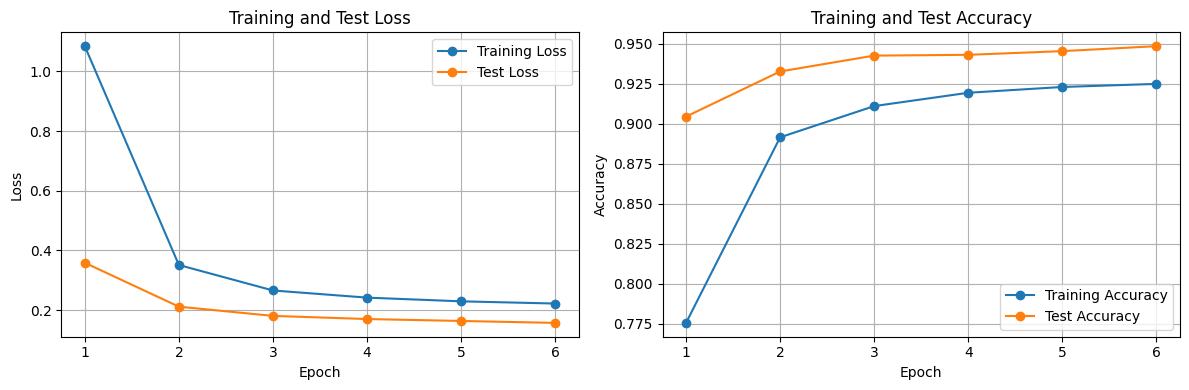

In [ ]:
trainer_efficientnet_v2_m_lion = ClassificationTrainer(model=efficientnet_v2_m,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=2,
                                         num_epochs=50)
trainer_efficientnet_v2_m_lion.train()
trainer_efficientnet_v2_m_lion.plot_training_history()

In [ ]:
class EfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2, self).__init__()
        self.efficientnet_v2_m = models.convnext_base(weights='DEFAULT')
        for param in self.efficientnet_v2_m.parameters(): param.requires_grad = False

        self.efficientnet_v2_m.classifier[2] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.efficientnet_v2_m.classifier[2].in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes))

    def forward(self, x):
        return self.efficientnet_v2_m(x)

In [ ]:
efficientnet_v2_m_v2 = EfficientNetV2(num_classes=10)
efficientnet_v2_m_v2 = efficientnet_v2_m_v2.to(device)


summary(efficientnet_v2_m_v2, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
       LayerNorm2d-2          [-1, 128, 56, 56]             256
            Conv2d-3          [-1, 128, 56, 56]           6,400
           Permute-4          [-1, 56, 56, 128]               0
         LayerNorm-5          [-1, 56, 56, 128]             256
            Linear-6          [-1, 56, 56, 512]          66,048
              GELU-7          [-1, 56, 56, 512]               0
            Linear-8          [-1, 56, 56, 128]          65,664
           Permute-9          [-1, 128, 56, 56]               0
  StochasticDepth-10          [-1, 128, 56, 56]               0
          CNBlock-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]           6,400
          Permute-13          [-1, 56, 56, 128]               0
        LayerNorm-14          [-1, 56, 

Обучение завершено!!!
Best accuracy: 0.9455


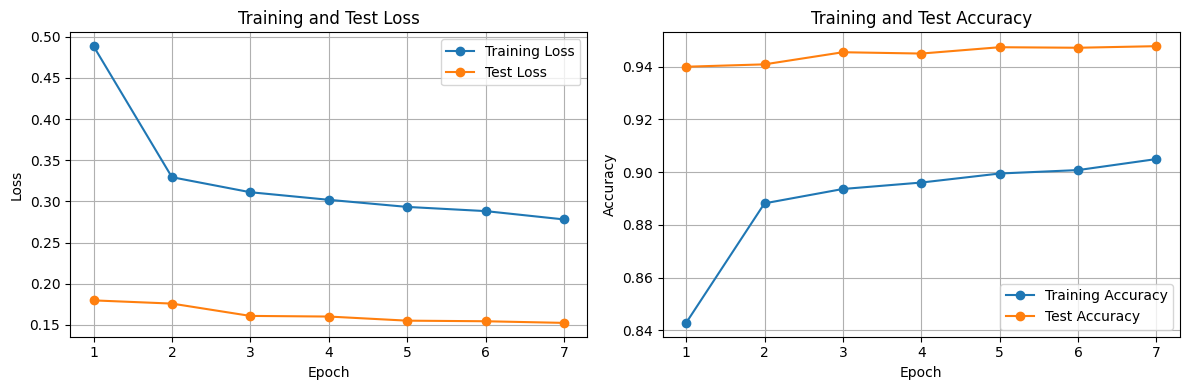

In [ ]:
trainer_efficientnet_v2_m_v2_lion = ClassificationTrainer(model=efficientnet_v2_m_v2,
                                         name_optimizer='Lion',
                                         scheduler=True,
                                         train_dataset=train_dataset,
                                         test_dataset=test_dataset,
                                         batch_size=128,
                                         learning_rate=1e-4,
                                         coef=0.85,
                                         step_size=1,
                                         num_epochs=50)
trainer_efficientnet_v2_m_v2_lion.train()
trainer_efficientnet_v2_m_v2_lion.plot_training_history()

Практически одинаковые результаты были получены, за исключением того случая, где мы усложнили слой классификации. В этот раз модель уже с первой эпохи показала результат в 0.94, в то время как первой модели потребовалось около 3 эпох.

Дополнительно, эксперименты с аугментацией данных могут улучшить результаты. Вероятно, модель является достаточно мощной для данного датасета, что подтверждается низким значением функции потерь.

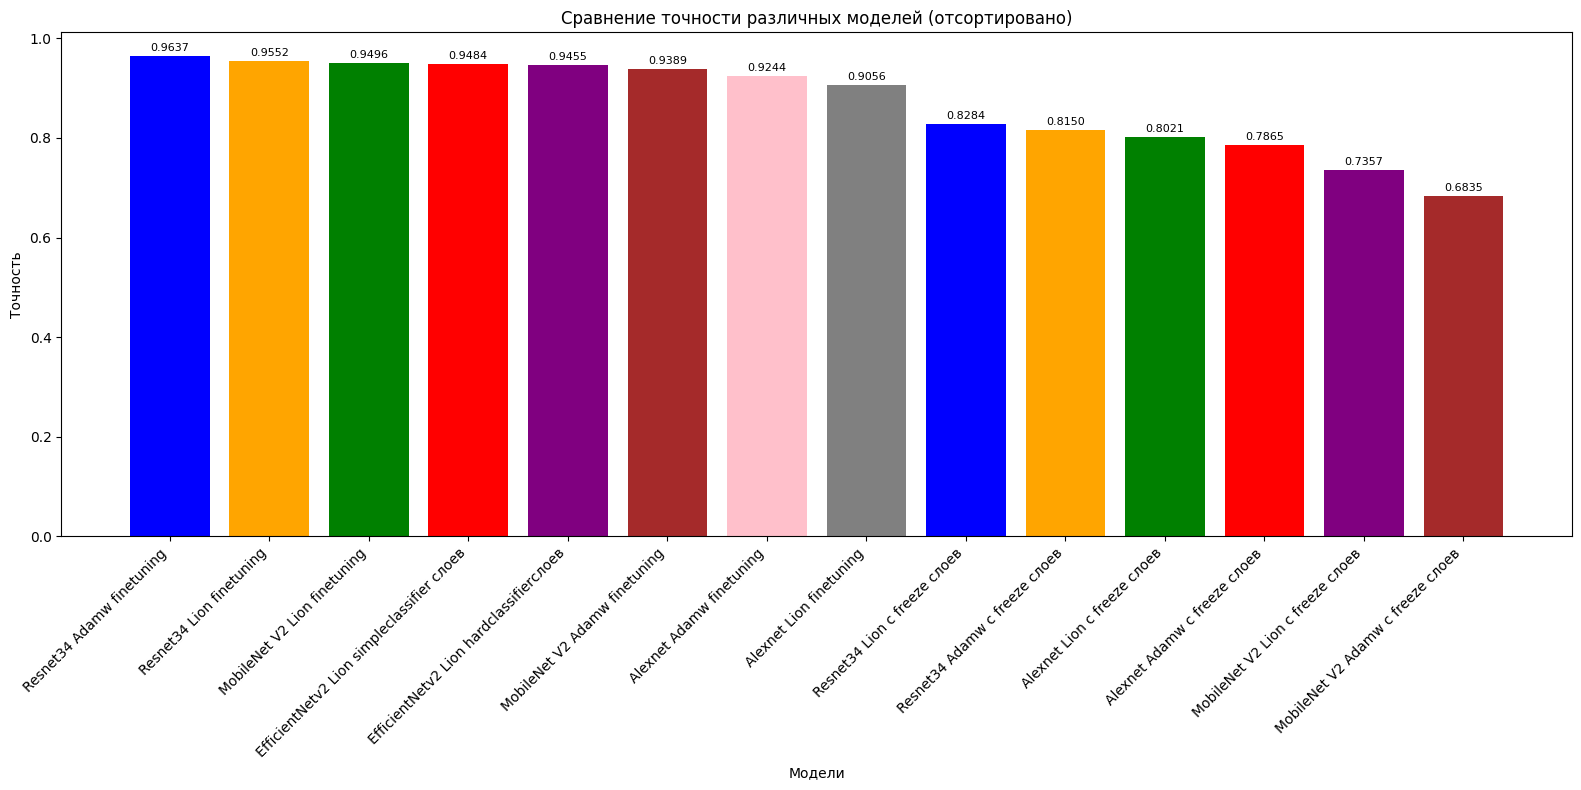

In [ ]:
models = [
    'Alexnet Lion с freeze слоев', 'Alexnet Adamw с freeze слоев', 'Alexnet Lion finetuning', 'Alexnet Adamw finetuning',
    'Resnet34 Lion с freeze слоев', 'Resnet34 Adamw с freeze слоев', 'Resnet34 Lion finetuning', 'Resnet34 Adamw finetuning',
    'MobileNet V2 Lion с freeze слоев', 'MobileNet V2 Adamw с freeze слоев', 'MobileNet V2 Lion finetuning', 'MobileNet V2 Adamw finetuning',
    'EfficientNetv2 Lion simpleclassifier слоев', 'EfficientNetv2 Lion hardclassifierслоев'
]
accuracies = [
    0.8021, 0.7865, 0.9056, 0.9244,
    0.8284, 0.815, 0.9552, 0.9637,
    0.7357, 0.6835, 0.9496, 0.9389,
    0.9484, 0.9455
]

sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k], reverse=True)
models_sorted = [models[i] for i in sorted_indices]
accuracies_sorted = [accuracies[i] for i in sorted_indices]

plt.figure(figsize=(16, 8))
bars = plt.bar(models_sorted, accuracies_sorted, color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])

for bar, accuracy in zip(bars, accuracies_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{accuracy:.4f}', ha='center', fontsize=8)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Модели')
plt.ylabel('Точность')
plt.title('Сравнение точности различных моделей (отсортировано)')


plt.tight_layout()
plt.show()


Исходя из графика, мы видим следующие результаты точности для различных моделей:

1. **Resnet34 Adamw finetuning** демонстрирует самую высокую точность (0.9637) среди всех моделей, когда используется Adamw для fine-tuning.

2. **Resnet34 Lion finetuning** и **EfficientNetv2 Lion simpleclassifier слоев** также показывают высокую точность (0.9552 и 0.9484 соответственно) после fine-tuning.

3. Модели **Alexnet Lion finetuning** и **Alexnet Adamw finetuning** имеют более низкую, но все равно впечатляющую точность после fine-tuning (0.9056 и 0.9244 соответственно).

4. Среди моделей с замороженными слоями, **Resnet34 Lion с freeze слоев** и **Alexnet Lion с freeze слоев** демонстрируют более высокую точность (0.8284 и 0.8021 соответственно) по сравнению с аналогичными моделями с использованием Adamw.

5. Также в данной работе опробовали новый оптимайзер Lion, который порой показывал довольно высокую скорость, как обучения, так и точности.

В данной работе рассмотрели модели с 2012 по 2020 год, можно сказать, что есть тенденция на уменьшения кол-во параметров для более высокой скорости работы моделей. Мы заметили как ResNet34 и MobileNetV2 показали почти одни и те же результаты, только разница в обучаемых параметрах была в 10 раз.